In [ ]:
from pathlib import Path
import numpy as np
import pandas as pd
import yaml
import earthaccess
import xarray as xr
import matplotlib.pyplot as plt
import contextily as ctx
from poseidon.data.sources.swot.download import SWOTDownloadConfig, run_swot_download
from poseidon.data.sources.swot.preprocess import (
from poseidon.data.sources.watermask import download as watermask_download
import rasterio


# Set Up Pure-Function Dependencies
This notebook shows how to drive the refactored SWOT download and preprocessing utilities using a config file, staying entirely within pure functions.

In [21]:


    filter_filenames_seasonality,
    load_multiple_seasonality_files,
    query_landmask_values_at_swot,
 )


## Load SWOT Data Configuration
We will read a YAML config that captures the bounding box, time window, and output directory expected by the downloader.

In [22]:
config_path = Path("../configs/data/swot_example.yaml")
raw_cfg = yaml.safe_load(config_path.read_text())
download_cfg = SWOTDownloadConfig.from_mapping(raw_cfg)

print(f"Product: {download_cfg.product} | passes: {download_cfg.passes}")
print(f"Temporal window: {download_cfg.start} → {download_cfg.end}")
print(f"Output directory: {download_cfg.outdir}")

pd.DataFrame(raw_cfg.items(), columns=["key", "value"])

Product: lr_any | passes: None
Temporal window: 2025-01-01 → 2025-01-05
Output directory: ../data/example/granules


,key,value
0,product,lr_any
1,bbox,"[-99.0, 17.0, -79.0, 31.0]"
2,start,2025-01-01
3,end,2025-01-05
4,outdir,../data/example/granules
5,dry_run,False
6,purge,False
7,granule_dir,../data/example/granules
8,watermask_dir,../data/example/watermask
9,shard_outdir,../data/example/whole_shards


## Download SWOT Tiles via Pure Function
Authenticate with NASA Earthdata (ensure your `~/.netrc` or environment variables are set) and trigger the real download workflow. This cell will contact the SWOT data API and write granules into the configured output directory.

In [23]:
                                         
                                                                                   
earthaccess.login(strategy="netrc")


download_cfg.outdir.mkdir(parents=True, exist_ok=True)

download_result = download_cfg.run()

summary = pd.Series(
    {
        "found": download_result.plan.found,
        "filtered": download_result.plan.filtered,
        "best": download_result.plan.best,
        "downloaded": len(download_result.downloaded),
        "deleted": len(download_result.deleted),
        "output_dir": str(download_cfg.outdir.resolve()),
    },
    name="download",
)

display(summary)

granules = sorted(download_cfg.outdir.glob("*.nc"))
if not granules:
    raise FileNotFoundError(
        "No SWOT granules were materialized. Double-check your config bbox/temporal window and credentials."
    )

pd.DataFrame({"granule": [path.name for path in granules]})


found                                                        11
filtered                                                     11
best                                                         11
downloaded                                                    0
deleted                                                       0
output_dir    /Users/mako3626/newfrontiers/poseidon/data/exa...
Name: download, dtype: object

,granule
0,SWOT_L2_LR_SSH_Expert_026_231_20250101T013336_...
1,SWOT_L2_LR_SSH_Expert_026_244_20250101T124225_...
2,SWOT_L2_LR_SSH_Expert_026_259_20250102T013407_...
3,SWOT_L2_LR_SSH_Expert_026_272_20250102T124256_...
4,SWOT_L2_LR_SSH_Expert_026_287_20250103T013438_...
5,SWOT_L2_LR_SSH_Expert_026_300_20250103T124327_...
6,SWOT_L2_LR_SSH_Expert_026_315_20250104T013509_...
7,SWOT_L2_LR_SSH_Expert_026_328_20250104T124358_...
8,SWOT_L2_LR_SSH_Expert_026_341_20250104T235343_...
9,SWOT_L2_LR_SSH_Expert_026_356_20250105T124428_...


## Plot Bounding Box Observations
Visualise a representative SWOT pass within the configured bounding box before any landmask filtering.

Using granule: SWOT_L2_LR_SSH_Expert_026_231_20250101T013336_20250101T022504_PIC2_01.nc


bbox_points         39432.0000
sampled_for_plot    15000.0000
ssh_min                -5.2022
ssh_max                 8.3678
Name: raw_bbox, dtype: float64

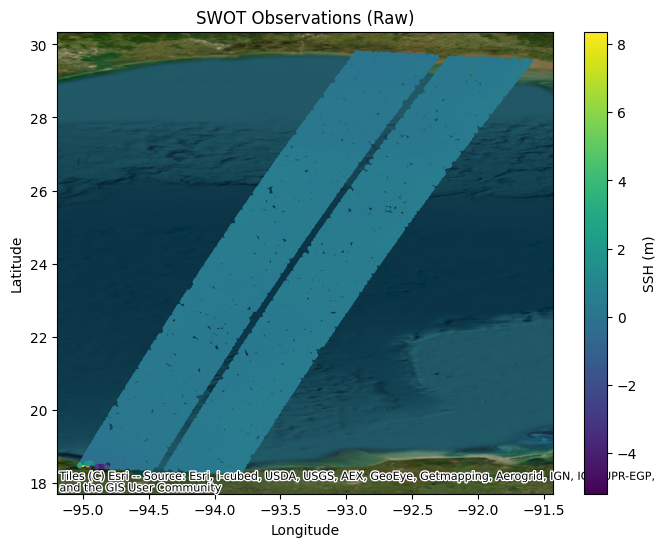

In [24]:
def first_available(dataset, candidates):
    for name in candidates:
        if name in dataset:
            return dataset[name]
    raise KeyError(f"None of {candidates} present in dataset")


def wrap_longitude(lon_array):
    return ((lon_array % 360) + 180) % 360 - 180


def sample_arrays(arrays, max_points=20000):
    lengths = [arr.size for arr in arrays]
    if not lengths:
        return arrays
    size = lengths[0]
    if any(length != size for length in lengths):
        raise ValueError("Arrays must be the same size to sample together")
    if size <= max_points:
        return arrays
    rng = np.random.default_rng(0)
    idx = rng.choice(size, size=max_points, replace=False)
    return [arr[idx] for arr in arrays]


granule_path = granules[0]
print(f"Using granule: {granule_path.name}")

with xr.open_dataset(granule_path) as ds:
    lat_all = first_available(ds, ("latitude", "lat")).values.ravel()
    lon_all = first_available(ds, ("longitude", "lon")).values.ravel()
    ssh = first_available(ds, ("ssh_karin", "ssh_karin2")).values.ravel()
    xover = first_available(ds, ("height_cor_xover",)).values.ravel()
    geoid = first_available(ds, ("geoid",)).values.ravel()

ssh_corrected = ssh + xover - geoid
lon_wrapped = wrap_longitude(lon_all)

bbox_mask = (
    np.isfinite(lat_all)
    & np.isfinite(lon_wrapped)
    & np.isfinite(ssh_corrected)
    & (lon_wrapped >= download_cfg.bbox[0])
    & (lon_wrapped <= download_cfg.bbox[2])
    & (lat_all >= download_cfg.bbox[1])
    & (lat_all <= download_cfg.bbox[3])
)

lat_bbox = lat_all[bbox_mask].astype(np.float32)
lon_bbox = lon_wrapped[bbox_mask].astype(np.float32)
ssh_bbox = ssh_corrected[bbox_mask].astype(np.float32)

if lat_bbox.size == 0:
    raise ValueError("No SWOT observations within the configured bounding box.")

lon_raw_plot, lat_raw_plot, ssh_raw_plot = sample_arrays([lon_bbox, lat_bbox, ssh_bbox], max_points=15000)

raw_summary = pd.Series(
    {
        "bbox_points": int(lon_bbox.size),
        "sampled_for_plot": int(lon_raw_plot.size),
        "ssh_min": float(np.nanmin(ssh_bbox)),
        "ssh_max": float(np.nanmax(ssh_bbox)),
    },
    name="raw_bbox",
)

display(raw_summary)

fig, ax = plt.subplots(figsize=(8, 6))
sc_raw = ax.scatter(lon_raw_plot, lat_raw_plot, c=ssh_raw_plot, s=6, cmap="viridis")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("SWOT Observations (Raw)")
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery, crs="EPSG:4326", zoom=7)
fig.colorbar(sc_raw, ax=ax, label="SSH (m)")
plt.show()

## Download Watermask Tiles
Pull the Global Surface Water tiles covering the Gulf bbox into the local `data/example/watermask` directory using the bundled downloader. Skip reruns once the tiles exist.

In [25]:

watermask_target = Path("../data/example/watermask")
watermask_target.mkdir(parents=True, exist_ok=True)

watermask_download.main([str(watermask_target), "seasonality"])

downloaded_tiles = sorted(watermask_target.glob("seasonality_*.tif"))
if not downloaded_tiles:
    raise FileNotFoundError(
        "No watermask tiles were downloaded. Verify network access and dataset arguments."
    )

pd.DataFrame({"tile": [path.name for path in downloaded_tiles]})

../data/example/watermask/seasonality_100W_40Nv1_4_2021.tif already exists - skipping
../data/example/watermask/seasonality_100W_30Nv1_4_2021.tif already exists - skipping
../data/example/watermask/seasonality_100W_20Nv1_4_2021.tif already exists - skipping
../data/example/watermask/seasonality_90W_40Nv1_4_2021.tif already exists - skipping
../data/example/watermask/seasonality_90W_30Nv1_4_2021.tif already exists - skipping
../data/example/watermask/seasonality_90W_20Nv1_4_2021.tif already exists - skipping
../data/example/watermask/seasonality_80W_40Nv1_4_2021.tif already exists - skipping
../data/example/watermask/seasonality_80W_30Nv1_4_2021.tif already exists - skipping
../data/example/watermask/seasonality_80W_20Nv1_4_2021.tif already exists - skipping


,tile
0,seasonality_100W_20Nv1_4_2021.tif
1,seasonality_100W_30Nv1_4_2021.tif
2,seasonality_100W_40Nv1_4_2021.tif
3,seasonality_80W_20Nv1_4_2021.tif
4,seasonality_80W_30Nv1_4_2021.tif
5,seasonality_80W_40Nv1_4_2021.tif
6,seasonality_90W_20Nv1_4_2021.tif
7,seasonality_90W_30Nv1_4_2021.tif
8,seasonality_90W_40Nv1_4_2021.tif


## Preprocess Downloaded Tiles
With real SWOT granules and watermask rasters on disk, merge the tiles across the bbox and sample landmask values at representative coordinates.

In [26]:

matched_tiles = filter_filenames_seasonality(watermask_target, download_cfg.bbox)
if not matched_tiles:
    raise FileNotFoundError(
        "No watermask tiles intersect the configured bbox. Ensure the correct tiles are downloaded."
    )

combined_data, combined_transform = load_multiple_seasonality_files(matched_tiles, download_cfg.bbox)
if combined_data is None or combined_transform is None:
    raise RuntimeError("Failed to assemble watermask raster from available tiles.")

sample_lons = np.linspace(download_cfg.bbox[0], download_cfg.bbox[2], 8)
sample_lats = np.linspace(download_cfg.bbox[1], download_cfg.bbox[3], 8)
landmask_samples = query_landmask_values_at_swot(
    sample_lons,
    sample_lats,
    combined_data,
    combined_transform,
    downsampling_factor=30,
)


/Users/mako3626/newfrontiers/newfrontiers/lib/python3.13/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


## Inspect Processed Outputs
Summarise the merged landmask array and sample the queried values to confirm preprocessing succeeds.

## Apply Landmask Filter
Use the merged watermask rasters to keep only ocean-coded observations.

In [27]:
if combined_data is None or combined_transform is None:
    raise RuntimeError("Combined landmask data was not created")

landmask_values = query_landmask_values_at_swot(
    lon_bbox,
    lat_bbox,
    combined_data,
    combined_transform,
    downsampling_factor=30,
 )
ocean_mask = np.isin(landmask_values, (12, 255))

lon_ocean = lon_bbox[ocean_mask]
lat_ocean = lat_bbox[ocean_mask]
ssh_ocean = ssh_bbox[ocean_mask]

if lon_ocean.size == 0:
    raise ValueError("Landmask filtering removed all points; verify watermask dataset and codes.")

lon_filtered_plot, lat_filtered_plot, ssh_filtered_plot = sample_arrays(
    [lon_ocean, lat_ocean, ssh_ocean], max_points=15000
 )

filter_summary = pd.Series(
    {
        "ocean_points": int(lon_ocean.size),
        "rejected": int(lon_bbox.size - lon_ocean.size),
        "sampled_for_plot": int(lon_filtered_plot.size),
    },
    name="landmask",
)

filter_summary

ocean_points        39094
rejected              338
sampled_for_plot    15000
Name: landmask, dtype: int64

## Plot Landmask-Filtered Observations
Visualise the retained ocean observations using the same basemap for comparison.

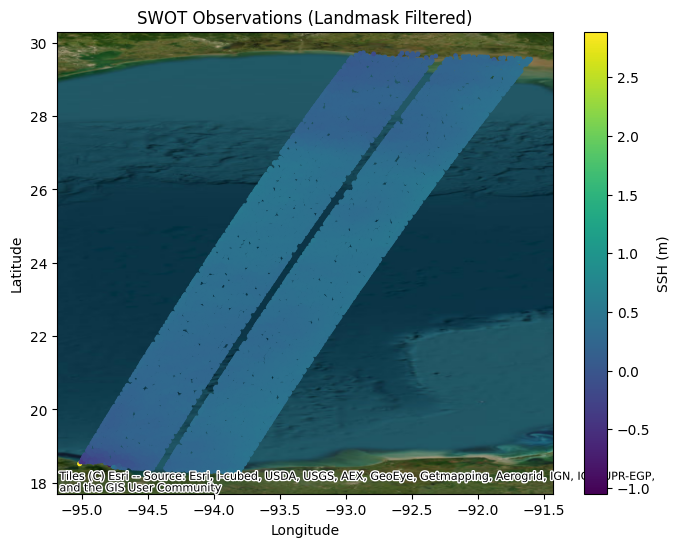

In [28]:
fig, ax = plt.subplots(figsize=(8, 6))
sc_filtered = ax.scatter(lon_filtered_plot, lat_filtered_plot, c=ssh_filtered_plot, s=6, cmap="viridis")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("SWOT Observations (Landmask Filtered)")
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery, crs="EPSG:4326", zoom=7)
fig.colorbar(sc_filtered, ax=ax, label="SSH (m)")
plt.show()

## Compare Raw vs Filtered Counts
Quickly review how many observations remain after applying the landmask filter.

In [29]:
comparison = pd.DataFrame(
    {
        "metric": ["points", "sampled"],
        "raw": [raw_summary["bbox_points"], raw_summary["sampled_for_plot"]],
        "filtered": [filter_summary["ocean_points"], filter_summary["sampled_for_plot"]],
    }
 )
comparison

,metric,raw,filtered
0,points,39432.0,39094
1,sampled,15000.0,15000


## Next Steps
Proceed to the sharding notebook to convert these filtered granules into training shards.